In [35]:
import numpy as np
import matplotlib.pyplot as plt
import smote_variants as sv
import imbalanced_databases as imbd
import pandas as pd
import time
import logging

from collections import Counter

from imblearn.metrics import geometric_mean_score, classification_report_imbalanced

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from synthsonic.models.kde_copula_nn_pdf import KDECopulaNNPdf

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, train_test_split
from sklearn.metrics import recall_score, roc_auc_score, f1_score, brier_score_loss, balanced_accuracy_score, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import preprocessing


le = preprocessing.LabelEncoder()
random_state=4

In [36]:
_logger = logging.getLogger('smote_variants')
_logger.setLevel(logging.DEBUG)
_logger_ch = logging.StreamHandler()
_logger_ch.setFormatter(logging.Formatter(
    "%(asctime)s:%(levelname)s:%(message)s"))
_logger.addHandler(_logger_ch)

In [37]:
class synthsonic(sv.OverSampling) :
    
    def __init__(self,
                 proportion=1.0,
                 distinct_threshold=-1,
                 n_jobs=1, 
                 random_state=random_state) :
        
        
        super().__init__()
        
        self.check_greater_or_equal(proportion, "proportion", 0)
        self.check_n_jobs(n_jobs, 'n_jobs')

        self.proportion = proportion
        self.distinct_threshold = distinct_threshold
        self.n_jobs = n_jobs

        self.set_random_state(random_state)
        
    @classmethod
    def parameter_combinations(cls, raw=False) :
        
        parameter_combinations = {'proportion': [0.1, 0.25, 0.5, 0.75,
                                                 1.0, 1.5, 2.0]}
        
        return cls.generate_parameter_combinations(parameter_combinations, raw)
    
    def sample(self, X, y) :
        
        _logger.info(self.__class__.__name__ + ": " +
                     "Running sampling via %s" % self.descriptor())
        
        # Find minority class
        # self.find_minority(X,y)
        self.class_label_statistics(X, y)
        
        self.X_min = X[y == self.min_label]
        
        print(f"minority class {self.min_label}, min dataset {self.X_min.shape}")
        
        # fit model
        kde = KDECopulaNNPdf(distinct_threshold=self.distinct_threshold)
        kde = kde.fit(self.X_min)
        
        # determine n_samples
        self.n_to_sample = self.det_n_to_sample(self.proportion,
                                           self.class_stats[self.maj_label],
                                           self.class_stats[self.min_label])

        
        # sample
        x1 = kde.sample_no_weights(n_samples=self.n_to_sample, mode='cheap')
        
        X_samp = np.vstack([X,x1])
        y_samp = np.hstack([y, [self.min_label]*self.n_to_sample])
        
        return X_samp, y_samp

    def get_params(self) :
        return {'proportion': self.proportion, 
                'n_jobs': self.n_jobs,
                'distinct_threshold':self.distinct_threshold,
                'random_state': self.random_state}
    


def writetodict(dataset,name) :
    
    data = dataset.iloc[:,:-1].values
    target = dataset.iloc[:,-1].values

    return {'data':data,
            'target':target,
            'name':name}
    
def plotter(X,y,title) :
    
    counter = Counter(y)
    
    for label, _ in counter.items() :
        rowix = np.where(y == label)[0]
        plt.scatter(X[rowix, 0], X[rowix, 1], label=str(label))
    plt.legend()
    plt.title(title)
    plt.show()

    print(counter)
    
def plot_oversampling(X,y, oversamplers) :
    
    for o in oversamplers:
        oversampler= o()
        X_samp, y_samp= oversampler.sample(X, y)

        plt.figure(figsize=(12, 5))
        ax= plt.subplot(121)
        plt.scatter(X[y == 0][:,0], X[y == 0][:,1], label='majority class', c='orange', marker='o')
        plt.scatter(X[y == 1][:,0], X[y == 1][:,1], label='minority class', c='olive', marker='o')
        plt.title('original')
        plt.xlabel('coordinate 0')
        plt.ylabel('coordinate 1')
        plt.legend()

        ax= plt.subplot(122)
        plt.scatter(X_samp[y_samp == 0][:,0], X_samp[y_samp == 0][:,1], label='majority class', c='orange', marker='o')
        plt.scatter(X_samp[y_samp == 1][:,0], X_samp[y_samp == 1][:,1], label='minority class', c='olive', marker='o')
        plt.title(oversampler.__class__.__name__)
        plt.xlabel('coordinate 0')
        plt.ylabel('coordinate 1')
        plt.legend()
        plt.show()

        
def evaluate_oversamplers(datasets, oversamplers, classifier, random_state) :

    results = []

    for data in datasets :
        
        X, y, name = data['data'], data['target'], data['name']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = random_state)
        
        for o in oversamplers :
            
        
            
            oversampler = o(random_state=random_state)
            print(oversampler)

            t0 = time.time()
            X_s,y_s = oversampler.sample(X_train, y_train)
            t1 = time.time() - t0

            classifier.fit(X_s,y_s)
            prediction = classifier.predict(X_test)
            proba = classifier.predict_proba(X_test)[:,1]

            f_dict = {
                'dataset':name,
                'sampler': oversampler.__class__.__name__,
                'clf_score': classifier.score(X_test,y_test),
                'accuracy': accuracy_score(y_test, prediction),
                'balanced acc': balanced_accuracy_score(y_test,prediction),
                'recall': recall_score(y_test,prediction),
                'roc_auc_score': roc_auc_score(y_test, proba),
                'f1_score': f1_score(y_test, prediction, average='binary'),
                'brier_score_loss': brier_score_loss(y_test, proba),
                'geometric mean': geometric_mean_score(y_test, prediction),
                'report': classification_report_imbalanced(y_test,prediction, target_names=['class 0', 'class 1']),
                'runtime': t1
            }

            results.append(f_dict)
            
    return results

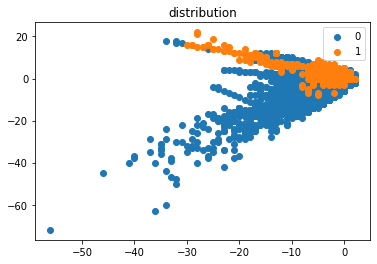

Counter({0: 284315, 1: 492})


In [38]:
# loading datasets

path = "/Users/tristenmarto/Documents/Studie/Thesis/Synthsonic_data_analysis/Datasets/"
data = path+"credit_fraud.csv"

data = pd.read_csv(data)

plotter(data.iloc[:,:-1].values,data.iloc[:,-1].values, "distribution")

data_dict = writetodict(data, 'credit_fraud')
X,y,name = data_dict['data'],data_dict['target'],data_dict['name']

In [39]:
datasets = [data_dict]
oversamplers = [synthsonic, sv.NoSMOTE, sv.SMOTE, sv.NT_SMOTE, sv.SMOTE_D]
classifier = DecisionTreeClassifier(random_state=random_state)
random_state = random_state

In [40]:
results = evaluate_oversamplers(datasets, oversamplers, classifier, random_state)

2021-06-04 13:00:36,806:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7F8AFA612D10}")
2021-06-04 13:00:36,806:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7F8AFA612D10}")
2021-06-04 13:00:36,806:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7F8AFA612D10}")
2021-06-04 13:00:36,806:INFO:synthsonic: Running sampling via ('synthsonic', "{'proportion': 1.0, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7F8AFA612D10}")
n_quantiles (500) is greater than the total number of samples (345). n_quantiles is set to num samples.


('synthsonic', "{'proportion': 1.0, 'n_jobs': 1, 'distinct_threshold': -1, 'random_state': RandomState(MT19937) at 0x7F8AFA612D10}")
minority class 1, min dataset (345, 29)


Building tree: 100%|██████████| 378/378.0 [00:00<00:00, 938.79it/s]
Generating for node: 18: 100%|██████████| 29/29 [00:06<00:00,  4.51it/s]
2021-06-04 13:01:14,946:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-06-04 13:01:14,946:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-06-04 13:01:14,946:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')
2021-06-04 13:01:14,946:INFO:NoSMOTE: Running sampling via ('NoSMOTE', '{}')


('NoSMOTE', '{}')


2021-06-04 13:01:16,982:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 4}")
2021-06-04 13:01:16,982:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 4}")
2021-06-04 13:01:16,982:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 4}")
2021-06-04 13:01:16,982:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 4}")


('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'n_jobs': 1, 'random_state': 4}")


2021-06-04 13:01:25,970:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': 4}")
2021-06-04 13:01:25,970:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': 4}")
2021-06-04 13:01:25,970:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': 4}")
2021-06-04 13:01:25,970:INFO:NT_SMOTE: Running sampling via ('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': 4}")


('NT_SMOTE', "{'proportion': 1.0, 'n_jobs': 1, 'random_state': 4}")


2021-06-04 13:01:38,500:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': 4}")
2021-06-04 13:01:38,500:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': 4}")
2021-06-04 13:01:38,500:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': 4}")
2021-06-04 13:01:38,500:INFO:SMOTE_D: Running sampling via ('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': 4}")


('SMOTE_D', "{'proportion': 1.0, 'k': 3, 'n_jobs': 1, 'random_state': 4}")


/Users/tristenmarto/anaconda3/lib/python3.7/site-packages/smote_variants/_smote_variants.py:10454: RuntimeWarning: invalid value encountered in true_divide
  p_ij = dist[:, 1:]/np.sum(dist[:, 1:], axis=1)[:, None]


In [41]:
resultdf = pd.DataFrame(results)
resultdf

,dataset,sampler,clf_score,accuracy,balanced acc,recall,roc_auc_score,f1_score,brier_score_loss,geometric mean,report,runtime
0,credit_fraud,synthsonic,0.999032,0.999032,0.870466,0.741497,0.870409,0.705502,0.000970,0.860859,pre rec spe ...,29.152789
1,credit_fraud,NoSMOTE,0.998872,0.998872,0.850010,0.700680,0.849941,0.660256,0.001130,0.836790,pre rec spe ...,0.034617
2,credit_fraud,SMOTE,0.998787,0.998787,0.843175,0.687075,0.843103,0.639241,0.001215,0.828599,pre rec spe ...,0.658580
3,credit_fraud,NT_SMOTE,0.998957,0.998957,0.850052,0.700680,0.849982,0.677632,0.001045,0.836826,pre rec spe ...,2.045455
4,credit_fraud,SMOTE_D,0.999138,0.999138,0.870519,0.741497,0.870459,0.729097,0.000864,0.860905,pre rec spe ...,1.841454


In [43]:
for i in range(5) :
    print(resultdf['sampler'][i])
    print(resultdf['report'][i])

synthsonic
                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.74      1.00      0.86      0.76     93840
    class 1       0.67      0.74      1.00      0.71      0.86      0.72       147

avg / total       1.00      1.00      0.74      1.00      0.86      0.76     93987

NoSMOTE
                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.70      1.00      0.84      0.72     93840
    class 1       0.62      0.70      1.00      0.66      0.84      0.68       147

avg / total       1.00      1.00      0.70      1.00      0.84      0.72     93987

SMOTE
                   pre       rec       spe        f1       geo       iba       sup

    class 0       1.00      1.00      0.69      1.00      0.83      0.71     93840
    class 1       0.60      0.69      1.00      0.64      0.83      0.67       147

avg / total       1.00      1.00      0.69      1.00  